## Cleaning and Visualization of Flights Metadata

Several IGC GPS files are missing. These flights are filtered from the master metadata.csv file and stored as a new file metadata_with_igc.csv. 

The filtered data is further analyzed and visualized.

In [ ]:
import pandas as pd
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# 1. Load metadata and filter for existing IGC files

# Load metadata
df = pd.read_csv("Flight data/metadata.csv")

# Path to folder with downloaded IGC files
igc_dir = Path("Flight data/igc")

# Collect flight_ids from filenames in the IGC folder
igc_files = list(igc_dir.glob("flight_*.igc"))
igc_ids = {int(re.search(r"flight_(\d+)\.igc", f.name).group(1)) for f in igc_files}

print(f"Found {len(igc_ids)} IGC files on disk")

# Filter metadata for only those flights
df_with_igc = df[df["flight_id"].isin(igc_ids)]

print(f"Filtered dataset: {len(df_with_igc)} rows (from {len(df)} originally)")

df = df_with_igc


Found 965 IGC files on disk
Filtered dataset: 965 rows (from 4973 originally)


In [15]:
display(df.sample(10))

,flight_id,index_cell,date,takeoff,duration,open_distance,total_distance,xc_score,glider_cat,glider_title,duration_min
643,3258963,326,2023-06-12 00:00:00,Hochkling - St.Veit/... - AT [~2.2],0:23,3.5,3.8,5.70,Paraglider - Open,Nova Xenon,23
1170,3175752,365,2022-06-14 00:00:00,"Kossen, Scheibenwald... - AT",1:23,3.1,6.9,12.07,Paraglider,NaN,83
785,3189927,481,2023-02-22 00:00:00,Bischling - AT,0:12,2.8,5.3,7.92,Paraglider - Sport,Icaro Paragliders Gravis2,12
703,3227745,399,2023-05-28 00:00:00,Elfer - AT,0:10,2.4,4.2,6.37,Paraglider -,Ozone Buzz Z4,10
567,3251244,241,2023-07-10 00:00:00,"Embergeralm, Greifen... - AT",1:02,4.7,15.1,22.67,Paraglider - Sport,PHI TENOR 23,62
324,3374563,363,2024-04-06,Stubaital - Kreuzjoc... - AT,3:28,13.3,32.2,56.40,Paraglider - Sport,PHI Maestro,208
836,3145972,8,2022-10-23 00:00:00,Bürgeralpe - AT,0:08,2.7,3.6,5.43,Paraglider - Open,Little Cloud GT2.6,8
1043,3165131,238,2022-07-25 00:00:00,Choralpe - AT,0:13,2.6,5.3,7.92,Paraglider - Open,PHI Tenor,13
315,3378397,354,2024-04-14,"Embergeralm, Greifen... - AT",3:46,13.4,52.3,91.56,Paraglider - Sport,Nova Xenon 17,226
1218,3074786,414,2022-05-20 00:00:00,"Embergeralm, Greifen... - AT",2:48,29.9,49.5,74.19,Paraglider - Sport,PHI Allegro X-Alps,168


In [ ]:
# 2. Add lon lat coordinates of flight start locations from the IGC files to the metadata

# Parse IGC start coordinates
def parse_igc_start(igc_path: Path):
    """Return first B-record lat/lon from IGC file (decimal degrees)."""
    try:
        with open(igc_path, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                if line.startswith("B"):  # GPS fix line
                    # Format: BHHMMSSDDMMmmmNDDDMMmmmE...
                    lat_raw = line[7:14]
                    lon_raw = line[15:23]
                    lat_hem = line[14]  # N/S
                    lon_hem = line[23]  # E/W

                    # Convert latitude
                    lat_deg = int(lat_raw[0:2])
                    lat_min = float(lat_raw[2:]) / 60000.0
                    lat = lat_deg + lat_min
                    if lat_hem == "S":
                        lat = -lat

                    # Convert longitude
                    lon_deg = int(lon_raw[0:3])
                    lon_min = float(lon_raw[3:]) / 60000.0
                    lon = lon_deg + lon_min
                    if lon_hem == "W":
                        lon = -lon

                    return lat, lon
    except Exception as e:
        print(f"⚠️ Failed to parse {igc_path}: {e}")
    return None, None


# Enrich metadata
igc_dir = Path("Flight data/igc")

coords = []
for flight_id in df["flight_id"]:
    igc_path = igc_dir / f"flight_{flight_id}.igc"
    if igc_path.exists():
        lat, lon = parse_igc_start(igc_path)
        coords.append((lat, lon))
    else:
        coords.append((None, None))

df["start_lat"], df["start_lon"] = zip(*coords)

# Filter to Austria bounding box
df = df[
    (df["start_lat"] >= 46) & (df["start_lat"] <= 49) &
    (df["start_lon"] >= 9)  & (df["start_lon"] <= 17)
]

# Save enriched DataFrame
out_file = Path("Flight data/metadata_with_igc.csv")
df.to_csv(out_file, index=False, encoding="utf-8")

print(f"✅ Saved enriched metadata with IGC GPS to {out_file}")
display(df.sample(10))

✅ Saved enriched metadata with IGC GPS to Flight data/metadata_with_igc.csv


,flight_id,index_cell,date,takeoff,duration,open_distance,total_distance,xc_score,glider_cat,glider_title,duration_min,start_lat,start_lon
279,3399669,301,2024-06-08,Elfer - AT,0:16,3.0,5.7,8.53,Paraglider - Sport,Advance Epsilon DLS,16,47.098700,11.324017
632,3236287,315,2023-06-18 00:00:00,Bischling - AT,1:11,4.5,12.9,25.74,Paraglider - Open,Gin Leopard,71,47.462367,13.297450
1080,3097258,275,2022-07-09 00:00:00,Hohe Salve - AT,2:45,11.9,34.7,69.36,Paraglider - Sport,PHI Maestro,165,47.465317,12.203317
3401,3025791,2714,2022-03-06 00:00:00,Stubaital - Kreuzjoc... - AT,1:31,12.3,30.8,53.87,Paraglider - Open,Ozone Mantra M7,91,47.145067,11.307833
311,3386250,349,2024-05-01,Radsberg - AT,1:16,2.8,9.3,14.00,Paraglider - Sport,Ozone Rush 5,76,46.572533,14.402200
2054,3043938,1305,2022-03-27 00:00:00,Bischling - AT,1:11,5.0,10.7,21.38,Paraglider -,Advance Alpha 7,71,47.462433,13.297567
841,3143438,13,2022-10-18 00:00:00,Hohe Salve - AT,0:19,4.7,8.0,12.05,Paraglider - Sport,NaN,19,47.465333,12.203350
1218,3074786,414,2022-05-20 00:00:00,"Embergeralm, Greifen... - AT",2:48,29.9,49.5,74.19,Paraglider - Sport,PHI Allegro X-Alps,168,46.772950,13.149500
352,3333125,1,2023-12-31 00:00:00,Erlsberg - AT [~1.5],0:10,1.4,2.3,3.46,Paraglider - Sport,Nova MENTOR 7 Light,10,47.470183,14.143050
1159,3087006,354,2022-06-17 00:00:00,"Kossen, Scheibenwald... - AT",1:35,7.1,17.0,25.56,Paraglider -,Ozone Alpina 4,95,47.624617,12.435917


/var/folders/zn/2ym95l4n2131dptxjp4dk3fh0000gn/T/ipykernel_48373/1406603674.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_df = df[numeric_cols].applymap(lambda x: np.log1p(x) if pd.notnull(x) else x)


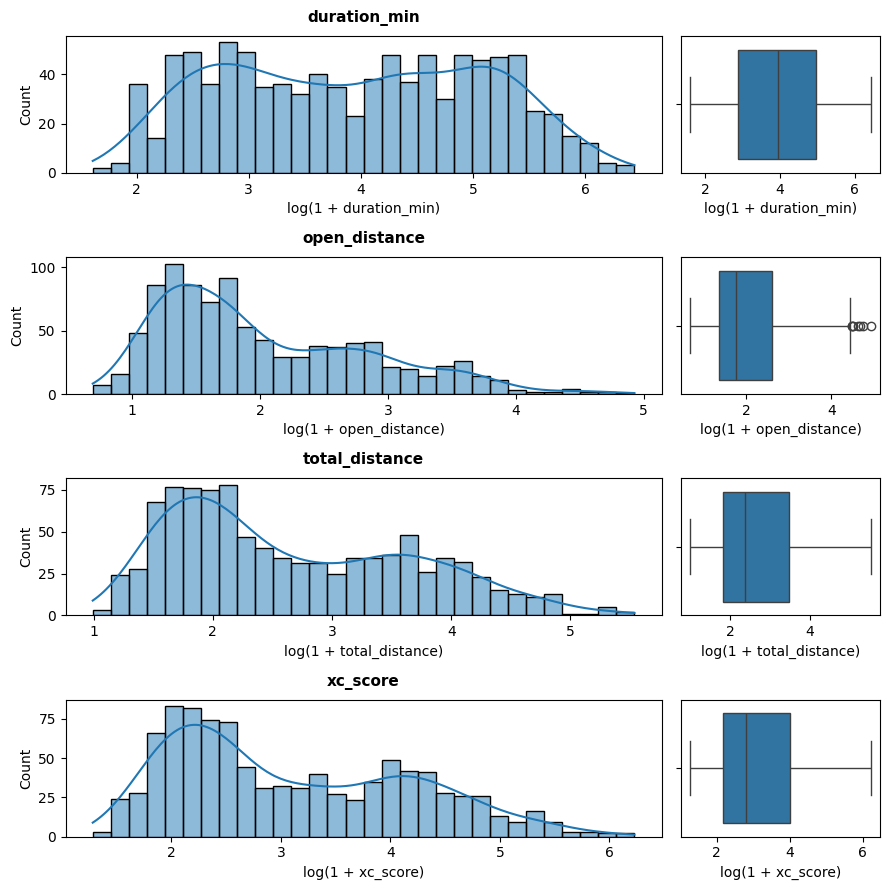

In [18]:
# 2. Visualize filtered data (this is only for flights with a corresponding IGC file)

# Pick numeric columns for EDA
numeric_cols = ["duration_min", "open_distance", "total_distance", "xc_score"]

# Apply log1p (log(1+x)) to avoid issues with 0 values
log_df = df[numeric_cols].applymap(lambda x: np.log1p(x) if pd.notnull(x) else x)

# Create a grid: 4 rows (variables), 2 columns (hist + boxplot)
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(9,9), 
                         gridspec_kw={'width_ratios': [3, 1]})

for i, col in enumerate(numeric_cols):
    # Histogram
    sns.histplot(log_df[col], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_xlabel(f"log(1 + {col})")

    # Boxplot
    sns.boxplot(x=log_df[col], ax=axes[i, 1])
    axes[i, 1].set_xlabel(f"log(1 + {col})")

    # Row headline
    axes[i, 0].set_title(f"{col}", fontsize=11, fontweight="bold", loc="center", pad=10)
    axes[i, 1].set_title("")

# Global figure adjustments
plt.tight_layout()
plt.show()

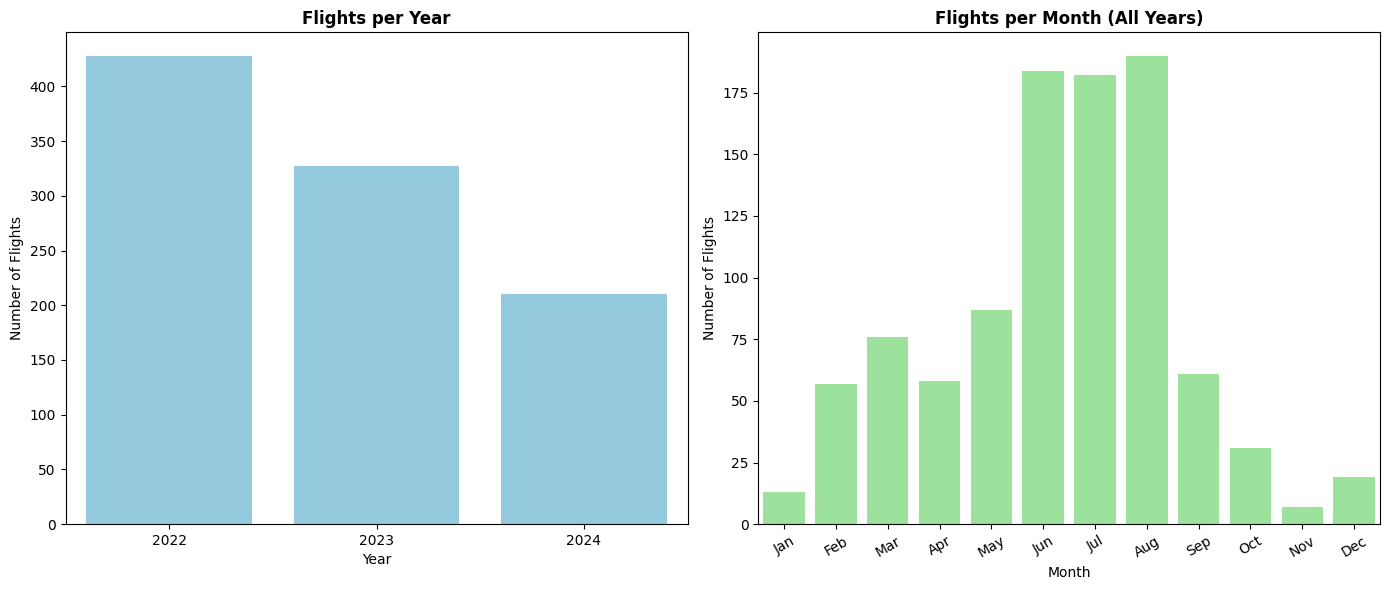

In [22]:


# Load metadata
df = pd.read_csv("Flight data/metadata_with_igc.csv")

# Ensure proper datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce", format="mixed")

# Extract year & month
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# --- Aggregate counts ---
flights_by_year = df["year"].value_counts().sort_index()
flights_by_month = df["month"].value_counts().sort_index()

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Flights per Year
sns.barplot(x=flights_by_year.index, y=flights_by_year.values, ax=axes[0], color="skyblue")
axes[0].set_title("Flights per Year", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Flights")

# Flights per Month (all years pooled)
sns.barplot(x=flights_by_month.index, y=flights_by_month.values, ax=axes[1], color="lightgreen")
axes[1].set_title("Flights per Month (All Years)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Number of Flights")
axes[1].set_xticks(range(0,12))
axes[1].set_xticklabels(
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    rotation=30
)

plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
# Example: make sure lat/lon columns are present
df = df.dropna(subset=["start_lat", "start_lon"])



print(df[["start_lat", "start_lon"]].sample(5))



✅ After filtering: 964 flights
     start_lat  start_lon
573  46.761167  13.201833
948  47.240050  13.127500
544  47.435183  12.093400
893  47.597033  13.954083
224  47.464100  13.299183
   start_lat  start_lon
0  47.464900  12.201900
1  47.469033  14.141250
2  46.766350   9.850617
3  46.764650   9.846400
4  47.598017  13.953733


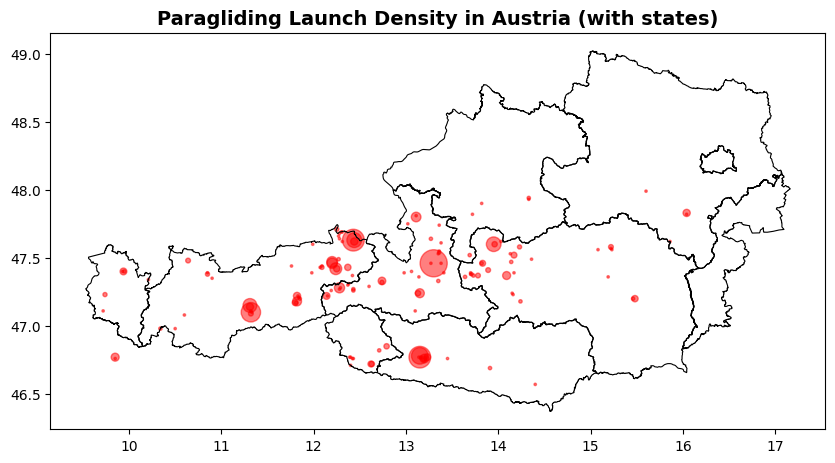

In [49]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# --- Austria ADM1 (federal states) ---
adm1_url = "https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/gbOpen/AUT/ADM1/geoBoundaries-AUT-ADM1.geojson"
austria_adm1 = gpd.read_file(adm1_url)

# Convert df to GeoDataFrame
coords = df.dropna(subset=["start_lat", "start_lon"])
coords = coords[
    (coords["start_lat"] >= 46) & (coords["start_lat"] <= 49) &
    (coords["start_lon"] >= 9)  & (coords["start_lon"] <= 17)
]

coords["lat_round"] = coords["start_lat"].round(2)
coords["lon_round"] = coords["start_lon"].round(2)

location_counts = coords.groupby(["lat_round", "lon_round"]).size().reset_index(name="count")

gdf = gpd.GeoDataFrame(
    location_counts,
    geometry=gpd.points_from_xy(location_counts["lon_round"], location_counts["lat_round"]),
    crs="EPSG:4326"
)

# Major Austrian cities
cities = {
    "Vienna": (48.2082, 16.3738),
    "Salzburg": (47.8095, 13.0550),
    "Innsbruck": (47.2692, 11.4041),
    "Graz": (47.0707, 15.4395),
    "Linz": (48.3069, 14.2858),
    "Klagenfurt": (46.6249, 14.3050),
    "Bregenz": (47.5031, 9.7471)
}

for name, (lat, lon) in cities.items():
    ax.text(lon, lat, name, fontsize=8, ha="center", va="center", color="blue")

# --- Plot with states ---
fig, ax = plt.subplots(figsize=(10, 8))
austria_adm1.boundary.plot(ax=ax, color="black", linewidth=0.8)

gdf.plot(
    ax=ax,
    markersize=gdf["count"] * 3,
    alpha=0.5,
    color="red"
)

ax.set_title("Paragliding Launch Density in Austria (with states)", fontsize=14, fontweight="bold")
plt.show()

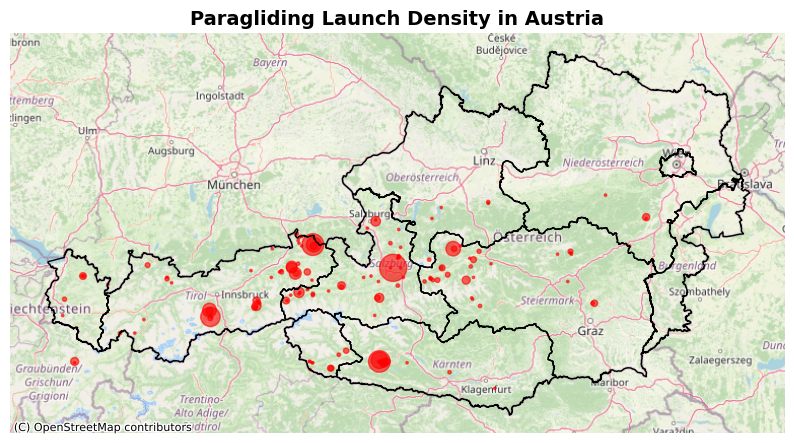

In [52]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx

# --- Austria ADM1 (federal states) ---
adm1_url = "https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/gbOpen/AUT/ADM1/geoBoundaries-AUT-ADM1.geojson"
austria_adm1 = gpd.read_file(adm1_url)

# Filter and prepare coords
coords = df.dropna(subset=["start_lat", "start_lon"])
coords = coords[
    (coords["start_lat"] >= 46) & (coords["start_lat"] <= 49) &
    (coords["start_lon"] >= 9)  & (coords["start_lon"] <= 17)
]

coords["lat_round"] = coords["start_lat"].round(2)
coords["lon_round"] = coords["start_lon"].round(2)
location_counts = coords.groupby(["lat_round", "lon_round"]).size().reset_index(name="count")

gdf = gpd.GeoDataFrame(
    location_counts,
    geometry=gpd.points_from_xy(location_counts["lon_round"], location_counts["lat_round"]),
    crs="EPSG:4326"
)

# Reproject both to Web Mercator (needed for contextily basemaps)
austria_adm1 = austria_adm1.to_crs(epsg=3857)
gdf = gdf.to_crs(epsg=3857)

# --- Plot with basemap ---
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Austria outline
austria_adm1.boundary.plot(ax=ax, color="black", linewidth=1)

# Plot paragliding launches, scaled by count
gdf.plot(
    ax=ax,
    markersize=gdf["count"] * 3,
    alpha=0.6,
    color="red"
)

# Add basemap (cities, rivers, roads, etc.)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Paragliding Launch Density in Austria", fontsize=14, fontweight="bold")
ax.set_axis_off()
plt.show()